# Preliminary CNN Training and Analysis

This is a brief example of the methodology used throughout the CNN training and analysis part of this project. 

#  Import packages

In [1]:
import numpy as np
import h5py
import glob
import re
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import pearsonr

np.set_printoptions(precision=3, suppress=True)

2024-02-14 14:08:18.312814: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 14:08:18.312841: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 14:08:18.312870: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-14 14:08:18.319367: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-14 14:08:19.589028: W tensorflow/compiler/

# Setup GPU

First, follow instructions [here](https://gist.github.com/zrruziev/b93e1292bf2ee39284f834ec7397ee9f), or alternatively run:
```bash
for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done
```
We do this as a workaround for [this error](https://github.com/tensorflow/tensorflow/issues/42738):

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
print(tf.config.list_physical_devices('GPU'), tf.test.gpu_device_name())

[] 


2024-02-14 14:08:25.970865: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-14 14:08:26.349400: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-02-14 14:08:26.353220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/t

# Import and prepare data

In [3]:
def extract_floats(string):
    return re.findall(r"[-+]?\d*\.\d+|\d+", string)

def data_load():
    density = 0.15
    files = glob.glob(f"../data/dataset_tumble_*_0.15.h5") #imports all tumbling rates for density 0.15
    inputs,outputs = [],[]
    for f in files:
        tumble = float(extract_floats(f)[0])
        with h5py.File(f, "r") as fin:
          count = 0
          for key in fin.keys():
              img = fin[key][:]
              img = img.reshape((img.shape[0], img.shape[1],1))
              shape = img.shape
              inputs.append(img)
              outputs.append(tumble)
              count+=1

    # Scramble the dataset
    order = np.arange(len(outputs)).astype(int)
    order = np.random.permutation(order)
    return np.array(inputs)[order],np.array(outputs)[order],shape

In [4]:
x,y,shape = data_load()

In [5]:
print("Number of unique alpha: ", len(np.unique(y)))
print("Shape of x: ", np.shape(x))
print("Shape of y: ", np.shape(y))

Number of unique alpha:  5
Shape of x:  (70000, 128, 128, 1)
Shape of y:  (70000,)


We have 10000 * number of unique alpha snapshots total, we split them into a training set and a validation set:

In [6]:
last = 20000
x_train, y_train = x[:-last], y[:-last]
x_val,y_val = x[-last:],y[-last:]

print("Size of training data: ", len(x_train))
print("Size of validation data: ", len(x_val))

Size of training data:  50000
Size of validation data:  20000


# Setup and train our model

In [7]:
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout,MaxPooling2D,BatchNormalization,AveragePooling2D,Normalization

import contextlib

@contextlib.contextmanager
def options(options):
  old_opts = tf.config.optimizer.get_experimental_options()
  tf.config.optimizer.set_experimental_options(options)
  try:
    yield
  finally:
    tf.config.optimizer.set_experimental_options(old_opts)

**Run this after analysis to reset model and release RAM before changing the architecture**

In [ ]:
import gc

K.clear_session()
del prediction
del model
del history

print("Collected: ", gc.collect())

## Setting up the model's architecture

In [8]:
model = Sequential()

model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', strides=(3,3), activation='relu', input_shape=shape))
model.add(BatchNormalization())
model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', input_shape=shape))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(3, 3)))

#model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=6, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=6, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Dense(units=128, activation='relu'))

with options({"layout_optimizer": False}):
    model.add(Dropout(0.2))
model.add(Dense(units=10, activation='softmax'))

model.add(Flatten())
model.add(Dense(units=1, activation='linear'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 43, 43, 3)         30        
                                                                 
 batch_normalization (Batch  (None, 43, 43, 3)         12        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 43, 43, 3)         84        
                                                                 
 batch_normalization_1 (Bat  (None, 43, 43, 3)         12        
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 3)         0         
 D)                                                              
                                                        

## Optimizer

In [10]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['accuracy'])

## Training and evaluation

Before training, these are the "predictions":

2024-02-14 14:12:29.587687: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1310720000 exceeds 10% of free system memory.


313/313 [==============================] - 8s 25ms/step
Shape of prediction :  (20000, 1)
Pearson's correlation coeff:  -0.04497726280558032


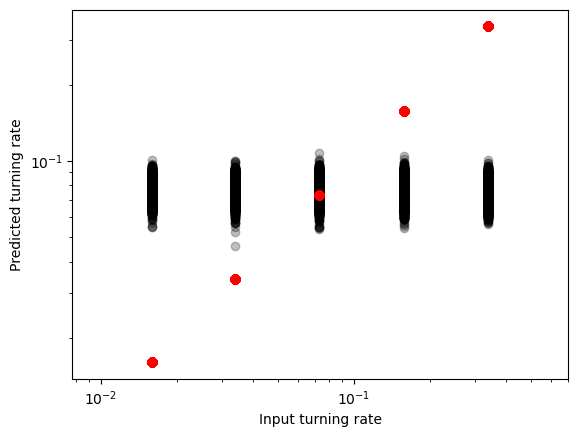

In [11]:
prediction = model.predict(x_val, batch_size=64)
print("Shape of prediction : ", np.shape(prediction))

plt.plot(y_val, prediction.T[0], 'o', c='k', alpha=0.25)
plt.plot(y_val, y_val, 'o', color='r')

print("Pearson's correlation coeff: ", pearsonr(y_val, prediction.T[0]).statistic)
plt.xlabel("Input turning rate")
plt.ylabel("Predicted turning rate")
plt.axis("equal")
plt.xscale("log")
plt.yscale("log")

Actual:  0.034
Predicted:  0.07371252


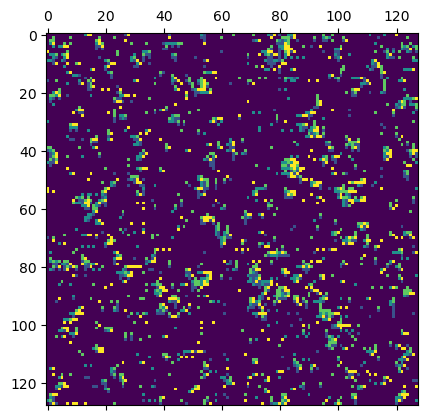

In [12]:
demo_idx = 100
plt.matshow(x_val[demo_idx])
print("Actual: ", y_val[demo_idx])
print("Predicted: ", prediction.T[0][demo_idx])

We can play with the architecture and see how the untrained predictions can change too.

## Run the training

In [13]:
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    verbose=True,
    batch_size=64,
    validation_data=(x_val, y_val)
)

Epoch 1/10


2024-02-14 14:13:58.918844: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3276800000 exceeds 10% of free system memory.


781/782 [============================>.] - ETA: 0s - loss: 0.0456 - accuracy: 0.0000e+00

2024-02-14 14:14:55.119286: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1310720000 exceeds 10% of free system memory.


782/782 [==============================] - 54s 66ms/step - loss: 0.0456 - accuracy: 0.0000e+00 - val_loss: 0.0635 - val_accuracy: 0.0000e+00
Epoch 2/10
782/782 [==============================] - 50s 64ms/step - loss: 0.0269 - accuracy: 0.0000e+00 - val_loss: 0.0202 - val_accuracy: 0.0000e+00
Epoch 3/10
782/782 [==============================] - 50s 64ms/step - loss: 0.0260 - accuracy: 0.0000e+00 - val_loss: 0.0207 - val_accuracy: 0.0000e+00
Epoch 4/10
782/782 [==============================] - 37s 48ms/step - loss: 0.0236 - accuracy: 0.0000e+00 - val_loss: 0.0161 - val_accuracy: 0.0000e+00
Epoch 5/10
782/782 [==============================] - 43s 55ms/step - loss: 0.0221 - accuracy: 0.0000e+00 - val_loss: 0.0196 - val_accuracy: 0.0000e+00
Epoch 6/10
782/782 [==============================] - 43s 55ms/step - loss: 0.0212 - accuracy: 0.0000e+00 - val_loss: 0.0200 - val_accuracy: 0.0000e+00
Epoch 7/10
782/782 [==============================] - 43s 55ms/step - loss: 0.0208 - accuracy: 0.00

In [14]:
print("Evaluate on test data:")
results = model.evaluate(x_val, y_val, batch_size=64, verbose=0)
print("Test loss:", results[0])
print("Test accuracy:", results[1])

Evaluate on test data:


2024-02-14 14:22:51.483660: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1310720000 exceeds 10% of free system memory.


Test loss: 0.01768036000430584
Test accuracy: 0.0


# Analyse training results

In [15]:
prediction = model.predict(x_val, batch_size=64)
print("Shape of prediction : ", np.shape(prediction))

2024-02-14 14:23:08.376226: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1310720000 exceeds 10% of free system memory.


313/313 [==============================] - 10s 32ms/step
Shape of prediction :  (20000, 1)


Pearson's correlation coeff:  0.9788006506188127


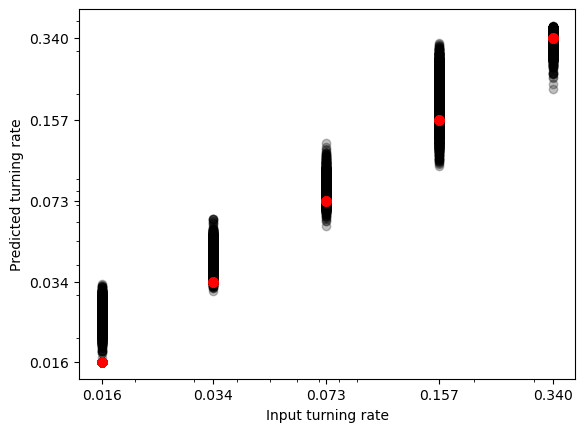

[0.016 0.034 0.073 0.157 0.34 ]


In [16]:
fig, ax = plt.subplots()

ax.plot(y_val, prediction.T[0], 'o', c='k', alpha=0.25)
ax.plot(y_val, y_val, 'o', color='r')

print("Pearson's correlation coeff: ", pearsonr(y_val, prediction.T[0]).statistic)
ax.set_xlabel("Input turning rate")
ax.set_ylabel("Predicted turning rate")
#ax.set_aspect("equal")
ax.set_xscale("log")
ax.set_yscale("log")
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xticks(np.unique(y))
ax.set_yticks(np.unique(y))
plt.show()
print(np.unique(y))

### Kernel analysis

3


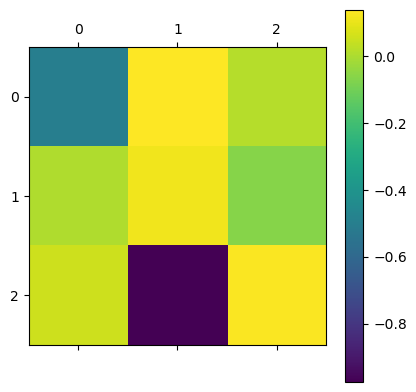

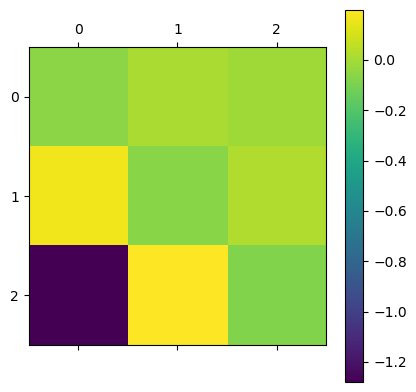

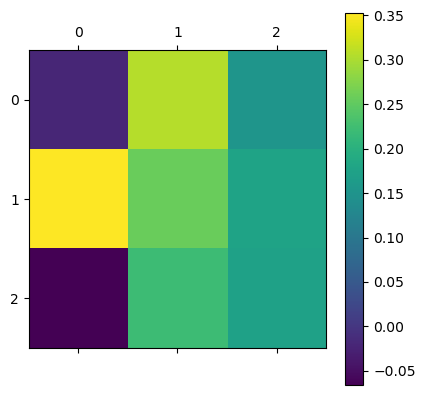

In [17]:
filters, biases = model.layers[0].get_weights()
print (filters.shape[-1])
for k in range(filters.shape[-1]):
  f = filters[:, :, :, k]
  plt.matshow(f.squeeze())
  plt.colorbar()

# Save model (if needed)

In [ ]:
model.save("../models/cp_14feb_prelim.keras")